# **CS224W - Colab 1**

이 Colab에서는 **노드 임베딩 학습**을 위한 전체 파이프라인을 작성할 것입니다. 우리는 다음의 3단계를 거쳐 진행할 예정입니다.

먼저, 네트워크 과학에서 클래식한 그래프인 [Karate Club 네트워크](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)를 로드할 것입니다. 이 그래프에 대해 여러 가지 그래프 통계치를 탐색할 것입니다.

그 다음, 그래프 구조를 PyTorch 텐서로 변환하여 그래프에 대해 머신러닝을 수행할 수 있도록 함께 작업할 것입니다.

마지막으로, 그래프에서의 첫 번째 학습 알고리즘인 노드 임베딩 모델을 구현할 것입니다. 간단히 하기 위해, 여기서 구현하는 모델은 강의에서 배운 DeepWalk / node2vec 알고리즘보다 단순합니다. 하지만 PyTorch를 통해 처음부터 직접 작성하는 만큼, 여전히 보람 있고 도전적인 작업이 될 것입니다.

그럼 시작해 봅시다! 이 Colab은 완료하는 데 1-2시간 정도 걸릴 수 있습니다.

**참고**: 제출하기 전에 **재시작 후 전체 실행**을 반드시 해주세요. 그래야 중간 변수나 패키지가 다음 셀로 제대로 이어집니다.

# 1 Graph Basics

먼저, 네트워크 과학에서 클래식한 그래프인 Karate Club 네트워크를 로드할 것입니다. 이 그래프에 대해 여러 가지 그래프 통계치를 탐색해 볼 예정입니다.

In [1]:
import networkx as nx

## Zachary's karate club network

[Karate Club 네트워크](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)는 34명의 가라테 클럽 회원들의 소셜 네트워크를 설명하는 그래프입니다. 이 그래프는 클럽 외부에서 상호작용한 회원들 간의 연결을 문서화하고 있습니다.

In [2]:
G = nx.karate_club_graph()

# G is an undirected graph
type(G)

networkx.classes.graph.Graph

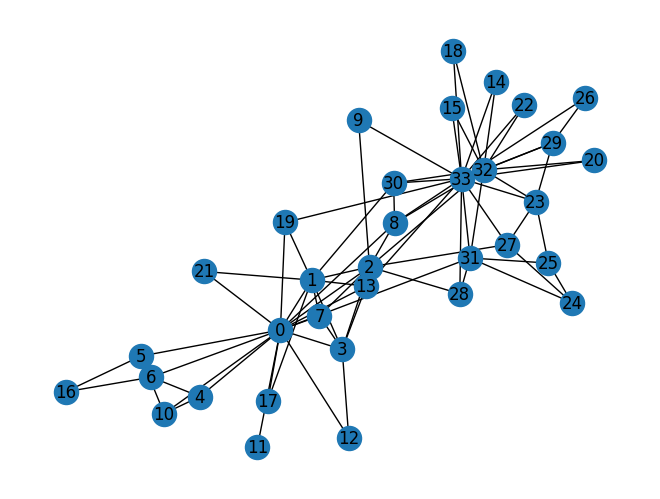

In [3]:
# Visualize the graph
nx.draw(G, with_labels = True)

## Question 1: What is the average degree of the karate club network? (5 Points)

In [ ]:
def average_degree(num_edges, num_nodes):
    # num_edges: 그래프의 엣지 수
    # num_nodes: 그래프의 노드 수
    # 이 함수는 엣지 수와 노드 수를 받아 평균 노드 차수를 계산하고,
    # 그 결과를 가장 가까운 정수로 반올림합니다.
    
    # 평균 노드 차수를 계산 (각 엣지는 두 개의 노드에 연결되므로 2를 곱함)
    avg_degree = round((2 * num_edges) / num_nodes)

    return avg_degree

# Karate Club 네트워크의 엣지와 노드 수 가져오기
num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()

# 평균 노드 차수 계산
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


## Question 2: What is the average clustering coefficient of the karate club network? (5 Points)

평균 클러스터링 계수를 구하는 로직
각 노드의 클러스터링 계수 계산:

특정 노드 v의 클러스터링 계수는 그 노드의 이웃들 간에 실제로 존재하는 엣지의 수를 가능한 모든 엣지 수로 나눈 값입니다.
가능한 모든 엣지 수는 n(n-1)/2이며, 여기서 n은 노드 v의 이웃의 수입니다.
평균 클러스터링 계수 계산:

모든 노드의 클러스터링 계수를 계산하고 그 값들의 평균을 구합니다.

In [ ]:
import networkx as nx

def average_clustering_coefficient(G):
    # G: NetworkX 그래프 객체
    # 이 함수는 그래프의 평균 클러스터링 계수를 계산하고,
    # 소수점 둘째 자리까지 반올림하여 반환합니다.
    
    # NetworkX의 average_clustering 함수를 사용해 평균 클러스터링 계수를 계산합니다.
    avg_cluster_coef = round(nx.average_clustering(G), 2)

    return avg_cluster_coef

# Karate Club 네트워크의 평균 클러스터링 계수 계산
avg_cluster_coef = average_clustering_coefficient(G)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))


Average clustering coefficient of karate club network is 0.57


## Question 3: What is the PageRank value for node 0 (node with id 0) after one PageRank iteration? (5 Points)

페이지 랭크(PageRank)는 웹의 링크 구조를 사용하여 그래프에서 노드의 중요성을 측정합니다. 중요한 페이지로부터의 “투표”는 더 높은 가치를 가집니다. 구체적으로, 중요도가 $ r_i$인 페이지 $ i $가 $ d_i $개의 아웃링크를 가지고 있을 때, 각 링크는 $ \frac{r_i}{d_i} $만큼의 투표를 받습니다. 따라서 페이지$ j $의 중요도 $ r_j $는 해당 페이지로 들어오는 링크들의 투표 합으로 표현됩니다.  

$$

r_j = \sum_{i \rightarrow j} \frac{r_i}{d_i}


$$

여기서 $ d_i $는 노드 $ i $의 아웃링크 수입니다.  

PageRank 알고리즘(구글에서 사용)은 랜덤 서퍼가 링크를 클릭하여 특정 페이지에 도달할 확률 분포를 출력합니다. 각 시간 단계에서 랜덤 서퍼는 두 가지 선택을 합니다:  
- 확률 $ \beta $로 무작위로 링크를 따라간다.
- 확률 $1 - \beta $로 무작위 페이지로 점프한다.  

따라서 특정 페이지의 중요도는 다음의 PageRank 방정식으로 계산됩니다:  
$$

r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}

$$
노드 0에 대해 위의 PageRank 방정식을 구현하는 코드 블록을 완성해 주세요.  

추가 정보를 보려면 이 슬라이드를 참고하세요: [PageRank 슬라이드](http://snap.stanford.edu/class/cs224w-2020/slides/04-pagerank.pdf)

In [10]:
G

In [11]:
def one_iter_pagerank(G, beta, r0, node_id):
    # r1 초기화
    r1 = 0

    # 해당 노드와 연결된 모든 이웃 노드를 고려
    for neighbor in G.neighbors(node_id):
        out_degree = G.degree(neighbor)  # 방향성이 없으므로 degree() 사용
        if out_degree > 0:
            r1 += beta * (r0 / out_degree)

    # 무작위 점프 확률 추가
    r1 += (1 - beta) * (1 / G.number_of_nodes())

    # 소수점 두 자리로 반올림
    r1 = round(r1, 2)

    return r1

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.13


## Question 4: What is the (raw) closeness centrality for the karate club network node 5? (5 Points)

The equation for closeness centrality is $c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$

In [13]:
import networkx as nx

def closeness_centrality(G, node=5):
    # 네트워크X의 closeness_centrality 함수를 사용하여 계산
    closeness = nx.closeness_centrality(G, node)
    
    # 소수점 두 자리로 반올림
    closeness = round(closeness, 2)

    return closeness

# 예제 그래프 (Karate Club Network)
G = nx.karate_club_graph()  # Karate Club 네트워크 생성

node = 5
closeness = closeness_centrality(G, node=node)
print("The node 5 has closeness centrality {}".format(closeness))


The node 5 has closeness centrality 0.38


`closeness_centrality`는 **NetworkX 라이브러리**에서 제공하는 함수로, **근접 중심성(Closeness Centrality)**을 계산합니다. 근접 중심성은 네트워크 그래프에서 특정 노드가 다른 모든 노드에 얼마나 가깝게 위치해 있는지를 나타내는 척도입니다.

### 근접 중심성 정의
- 근접 중심성은 **특정 노드에서 다른 모든 노드까지의 최단 경로의 평균 길이의 역수**로 정의됩니다.
- 직관적으로, 근접 중심성 값이 클수록 그 노드는 다른 노드들에 더 빨리 도달할 수 있습니다.

### `closeness_centrality` 메서드 설명
- `nx.closeness_centrality(G, node)`: 그래프 `G`에서 지정된 `node`의 근접 중심성을 계산합니다.
- 이 함수는 **정규화된 근접 중심성** 값을 반환합니다. 즉, 계산된 중심성 값이 네트워크 크기에 따라 조정됩니다.

### 사용 예시
- **소셜 네트워크 분석**: 네트워크 내에서 정보가 얼마나 빠르게 퍼질 수 있는지를 측정할 때 사용합니다.
- **네트워크 분석**: 그래프에서 중요한 노드나 중심적인 역할을 하는 노드를 식별할 때 유용합니다.

예를 들어, 소셜 네트워크에서 근접 중심성이 높은 사람은 다른 사람들에게 정보를 빠르게 전달할 수 있는 위치에 있는 사람입니다.

# 2 Graph to Tensor
We will then work together to transform the graph $G$ into a PyTorch tensor, so that we can perform machine learning over the graph.

## Setup
Check if PyTorch is properly installed

In [14]:
import torch
print(torch.__version__)

2.3.0+cpu


## PyTorch tensor basics

We can generate PyTorch tensor with all zeros, ones or random values.

In [15]:
# Generate 3 x 4 tensor with all ones
ones = torch.ones(3, 4)
print(ones)

# Generate 3 x 4 tensor with all zeros
zeros = torch.zeros(3, 4)
print(zeros)

# Generate 3 x 4 tensor with random values on the interval [0, 1)
random_tensor = torch.rand(3, 4)
print(random_tensor)

# Get the shape of the tensor
print(ones.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.7484, 0.3123, 0.0703, 0.2585],
        [0.1394, 0.7610, 0.5720, 0.4307],
        [0.9098, 0.3816, 0.6276, 0.3102]])
torch.Size([3, 4])


PyTorch tensor contains elements for a single data type, the `dtype`.

In [ ]:
# Create a 3 x 4 tensor with all 32-bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# Change the tensor dtype to 64-bit integer
zeros = zeros.type(torch.long)
print(zeros.dtype)

## Question 5: Get the edge list of the karate club network and transform it into `torch.LongTensor`. What is the `torch.sum` value of `pos_edge_index` tensor? (10 Points)

In [16]:
def graph_to_edge_list(G):
    # G.edges()를 사용하여 엣지 리스트를 가져옴
    edge_list = list(G.edges())
    return edge_list

def edge_list_to_tensor(edge_list):
    # 각 엣지 튜플을 (출발 노드, 도착 노드) 형태의 리스트로 분리
    edge_index = torch.tensor(edge_list, dtype=torch.long).t()
    return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


## 질문 6: 아래 함수를 구현하여 부정적(negative) 엣지를 샘플링하세요. 그런 다음, 가라테 클럽 네트워크에서 어떤 엣지(edge_1부터 edge_5까지)가 부정적 엣지인지 답변하세요. (10점)

"부정적(negative)" 엣지는 그래프에 존재하지 않는 엣지/링크를 의미합니다. "부정적"이라는 용어는 링크 예측에서 "부정적 샘플링(negative sampling)"에서 차용된 것이며, 엣지 가중치와는 관련이 없습니다.

예를 들어, 엣지 (src, dst)가 주어지면, (src, dst)와 (dst, src) 둘 다 그래프에 존재하지 않는지를 확인해야 합니다. 이 조건이 참일 경우, 해당 엣지는 부정적 엣지입니다.

In [17]:
import random

def sample_negative_edges(G, num_neg_samples):
    # 부정적 엣지를 저장할 리스트
    neg_edge_list = []
    nodes = list(G.nodes())
    num_nodes = len(nodes)
    
    while len(neg_edge_list) < num_neg_samples:
        # 무작위로 두 개의 노드를 선택
        src = random.choice(nodes)
        dst = random.choice(nodes)
        
        # 자기 자신으로의 엣지나 이미 존재하는 엣지를 방지
        if src != dst and not G.has_edge(src, dst) and not G.has_edge(dst, src):
            neg_edge_list.append((src, dst))
    
    return neg_edge_list


# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

def can_be_negative(G, edge):
    src, dst = edge
    # 자기 자신으로의 엣지가 아니고, 그래프에 존재하지 않는 엣지인 경우
    is_negative = src != dst and not G.has_edge(src, dst) and not G.has_edge(dst, src)
    return is_negative

print(f"Edge 1 can be a negative edge: {can_be_negative(G, edge_1)}")
print(f"Edge 2 can be a negative edge: {can_be_negative(G, edge_2)}")
print(f"Edge 3 can be a negative edge: {can_be_negative(G, edge_3)}")
print(f"Edge 4 can be a negative edge: {can_be_negative(G, edge_4)}")
print(f"Edge 5 can be a negative edge: {can_be_negative(G, edge_5)}")

The neg_edge_index tensor has shape torch.Size([2, 78])
Edge 1 can be a negative edge: False
Edge 2 can be a negative edge: True
Edge 3 can be a negative edge: False
Edge 4 can be a negative edge: False
Edge 5 can be a negative edge: True


# 3 Node Emebedding Learning

Finally, we will finish the first learning algorithm on graphs: a node embedding model.


## Setup

In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


print(torch.__version__)

2.3.0+cpu


To write our own node embedding learning methods, we'll heavily use the [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module in PyTorch. Let's see how to use `nn.Embedding`:

In [19]:
# Initialize an embedding layer
# Suppose we want to have embedding for 4 items (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


We can select items from the embedding matrix, by using Tensor indices

In [20]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initilized
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[ 0.1252, -0.8911, -0.7662, -0.3819,  1.7947,  0.5961,  0.0026, -1.8281]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 0.1252, -0.8911, -0.7662, -0.3819,  1.7947,  0.5961,  0.0026, -1.8281],
        [-0.0244, -0.6642, -0.8839,  0.0960,  0.5144,  0.0517, -0.8290,  1.3631]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


Now, it's your time to create node embedding matrix for the graph we have!
- We want to have **16 dimensional** vector for each node in the karate club network.
- We want to initalize the matrix under **uniform distribution**, in the range of $[0, 1)$. We suggest you using [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).

In [21]:
import torch
import torch.nn as nn

# 난수 시드를 고정합니다. (변경하지 마세요)
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
    # torch.nn.Embedding 레이어 생성
    emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)
    
    # 가중치를 균등 분포로 초기화
    nn.init.uniform_(emb.weight, a=0.0, b=1.0)
    
    return emb

# 임베딩 레이어 생성
emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# 임베딩 레이어 출력
print("Embedding: {}".format(emb))

# 노드 0과 3에 해당하는 임베딩 출력
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward0>)


## Visualize the initial node embeddings
One good way to understand an embedding matrix, is to visualize it in a 2D space.
Here, we have implemented an embedding visualization function for you.
We first do PCA to reduce the dimensionality of embeddings to a 2D space.
Then we visualize each point, colored by the community it belongs to.

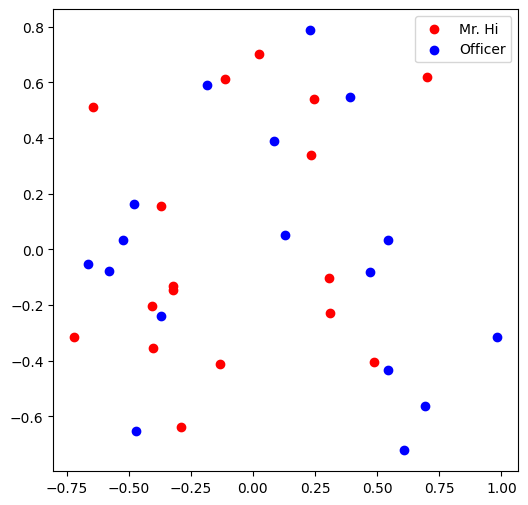

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_emb(emb):
    # 임베딩 레이어의 가중치를 NumPy 배열로 변환
    X = emb.weight.data.numpy()
    
    # PCA를 사용하여 임베딩을 2차원으로 축소
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)
    
    # 그래프 크기 설정
    plt.figure(figsize=(6, 6))
    
    # 각 클럽의 좌표를 저장할 리스트 초기화
    club1_x = []  # Mr. Hi 클럽의 x 좌표
    club1_y = []  # Mr. Hi 클럽의 y 좌표
    club2_x = []  # Officer 클럽의 x 좌표
    club2_y = []  # Officer 클럽의 y 좌표
    
    # 그래프의 모든 노드를 반복하면서 클럽에 따라 좌표를 분류
    for node in G.nodes(data=True):
        if node[1]['club'] == 'Mr. Hi':
            # Mr. Hi 클럽에 속하는 노드의 좌표 추가
            club1_x.append(components[node[0]][0])
            club1_y.append(components[node[0]][1])
        else:
            # Officer 클럽에 속하는 노드의 좌표 추가
            club2_x.append(components[node[0]][0])
            club2_y.append(components[node[0]][1])
    
    # Mr. Hi 클럽 노드들을 빨간색으로 시각화
    plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
    # Officer 클럽 노드들을 파란색으로 시각화
    plt.scatter(club2_x, club2_y, color="blue", label="Officer")
    
    # 범례 추가
    plt.legend()
    # 시각화된 그래프 출력
    plt.show()

# 초기 랜덤 임베딩을 시각화
visualize_emb(emb)


## 질문 7: 임베딩 학습! 최고의 성능을 얻을 수 있나요? (20점)

엣지를 긍정적(positive) 또는 부정적(negative)으로 분류하는 작업을 위해 임베딩을 최적화하고자 합니다. 엣지와 각 노드의 임베딩이 주어지면, 임베딩의 **내적(dot product)**을 계산한 후 **시그모이드(sigmoid)**를 적용하여 해당 엣지가 긍정적인지(시그모이드 출력 > 0.5) 또는 부정적인지(시그모이드 출력 < 0.5)에 대한 가능성을 얻어야 합니다.

참고로, 이전 문제에서 작성한 함수들과 초기화된 변수들을 사용할 것입니다. 문제가 발생할 경우, 1-6번 질문에 대한 답이 올바른지 확인하세요.

In [24]:
from torch.optim import SGD
import torch.nn as nn

def accuracy(pred, label):
    # 시그모이드 결과가 0.5보다 크면 1로, 아니면 0으로 분류
    pred_label = (pred > 0.5).long()
    
    # 예측 레이블과 실제 레이블이 일치하는 비율 계산
    accu = (pred_label == label).sum().item() / label.size(0)
    
    # 소수점 4자리로 반올림
    accu = round(accu, 4)
    
    return accu


def train(emb, loss_fn, train_label, train_edge):
    epochs = 500
    learning_rate = 0.1

    # SGD 옵티마이저 초기화
    optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

    for epoch in range(epochs):
        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # (1) 노드 임베딩 가져오기
        src_emb = emb(train_edge[0])
        dst_emb = emb(train_edge[1])

        # (2) 노드 임베딩의 내적 계산
        dot_product = torch.sum(src_emb * dst_emb, dim=1)

        # (3) 시그모이드 적용
        sigmoid = torch.sigmoid(dot_product)

        # (4) 손실 함수에 시그모이드 출력과 레이블 전달
        loss = loss_fn(sigmoid, train_label)

        # (5) 손실과 정확도 출력
        acc = accuracy(sigmoid, train_label)
        if epoch % 50 == 0:  # 매 50 에포크마다 출력
            print(f"Epoch {epoch}: Loss = {loss.item()}, Accuracy = {acc}")

        # 역전파 및 파라미터 업데이트
        loss.backward()
        optimizer.step()

    return emb


loss_fn = nn.BCELoss()

print(pos_edge_index.shape)

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

train(emb, loss_fn, train_label, train_edge)

torch.Size([2, 78])
torch.Size([2, 156])


c:\Users\Hi\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 0: Loss = 2.016669511795044, Accuracy = 0.5
Epoch 50: Loss = 0.5078207850456238, Accuracy = 0.7949
Epoch 100: Loss = 0.32862070202827454, Accuracy = 0.9423
Epoch 150: Loss = 0.19307026267051697, Accuracy = 0.9808
Epoch 200: Loss = 0.11321185529232025, Accuracy = 1.0
Epoch 250: Loss = 0.07108310610055923, Accuracy = 1.0
Epoch 300: Loss = 0.04845314845442772, Accuracy = 1.0
Epoch 350: Loss = 0.03542429208755493, Accuracy = 1.0
Epoch 400: Loss = 0.02731771022081375, Accuracy = 1.0
Epoch 450: Loss = 0.021923333406448364, Accuracy = 1.0


Embedding(34, 16)

## 최종 노드 임베딩 시각화  
여기서 최종 임베딩을 시각화하세요!  
이전 임베딩 그림과 시각적으로 비교할 수 있습니다.  
학습 후, 두 클래스가 더 뚜렷하게 분리된 것을 관찰할 수 있어야 합니다.  
이것은 여러분의 구현이 제대로 되었는지를 확인하는 훌륭한 검증 방법이기도 합니다.

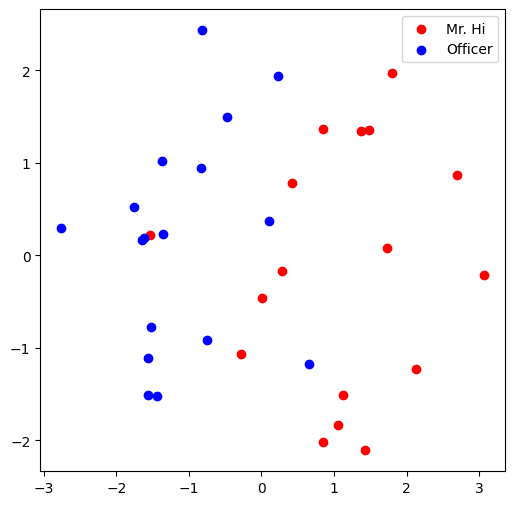

In [25]:
# Visualize the final learned embedding
visualize_emb(emb)

# Submission

When you submit your assignment, you will have to download this file as an `.ipynb` file. Please name this file `CS224W_Colab_1.ipynb`. Make sure that the files are name correctly, otherwise the autograder will not be able to find your submission files.